In [1]:
cd ..

C:\Users\688228hh\Kalman-Heston-Filter


In [2]:
from src.Utility import Utility, MeasurementType
from src.KalmanFilterSV import HestonKalmanFilter
from src.KalmanFilterCorr import HestonKalmanFilterCorr
from src.ParticleFilter import PFHeston
from src.RealizedGARCH import RealizedGARCH
from src.Heston import *
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from arch import arch_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [3]:
# Set initial conditions and simulation parameters
S0 = 100
V0 = 0.04
params = {
    'mu': 0.05,
    'rho': -0.8,
    'kappa': 5.0,
    'theta': 0.04,
    'xi': 0.35
}
std_asy = np.sqrt(params['theta'] * params['xi']**2 / (2 * params['kappa']))
feller_cond = 2 * params['kappa'] * params['theta'] / params['xi']**2
print(round(feller_cond, 2))
assert feller_cond > 1, "Feller condition is violated!"

Hest = Heston(**params)
time_daily, S_daily, daily_returns, daily_true_V, daily_RV = Hest.path_simulation(
    S0, V0, T_years=1.5, trading_days=252, intraday_intervals=39, seed=40
)
R_daily = daily_returns.copy()

3.27


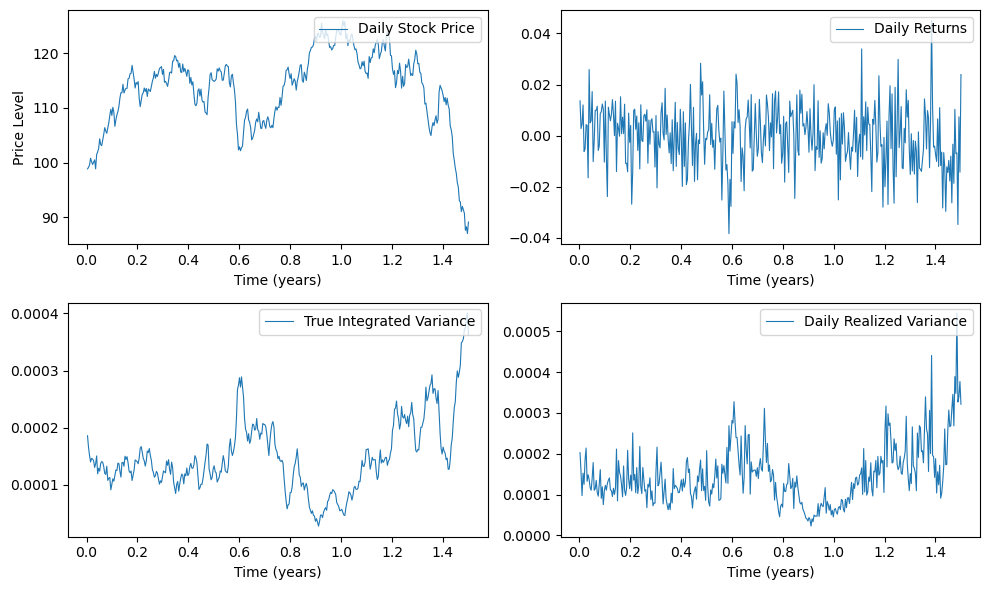

In [4]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# Subplot for BOTH measurements
axes[0,0].plot(time_daily, S_daily, label="Daily Stock Price", lw=0.8)
axes[0,0].set_xlabel("Time (years)")
axes[0,0].set_ylabel("Price Level")
axes[0,0].legend(loc="upper right")

# Subplot for RETURNS measurement
axes[0,1].plot(time_daily, daily_returns, label="Daily Returns", lw=0.8)
axes[0,1].set_xlabel("Time (years)")
axes[0,1].legend(loc="upper right")

# Subplot for RV measurement
axes[1,0].plot(time_daily, daily_true_V, label="True Integrated Variance", lw=0.8)
axes[1,0].set_xlabel("Time (years)")
axes[1,0].legend(loc="upper right")

# Subplot for RV measurement
axes[1,1].plot(time_daily, daily_RV, label="Daily Realized Variance", lw=0.8)
axes[1,1].set_xlabel("Time (years)")
axes[1,1].legend(loc="upper right")

plt.tight_layout()
plt.show()

In [5]:
burnin = 252
dt = 1  # Daily

split_index = round(0.6 * 252 * 1.5)

# TRAINING SET 
train_returns = daily_returns[:split_index]
train_RV = daily_RV[:split_index]

# TEST SET 
test_returns = daily_returns[split_index:]
test_RV = daily_RV[split_index:]

### Both - Corr

In [6]:
hkf_both_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=0.01, P0=0.1)
hkf_both_corr.set_data(returns=train_returns, rv=train_RV)
initial_params_both_corr = np.array([0.05, 0.0001, 0.001, 0.001, 0.001, -0.2])
# initial_params_both_corr = np.array([0.1, 0.01, 0.01, 0.001, 0.001, -0.1])

fit_results_both_corr = hkf_both_corr.fit(initial_params=initial_params_both_corr, burnin=burnin)
params_opt_both_corr = fit_results_both_corr['params']
print("Optimized parameters (BOTH):", params_opt_both_corr)

train_result_both_corr = hkf_both_corr.filter(params_opt_both_corr)
last_V_train_corr = train_result_both_corr['V_filt'][-1]
last_P_train_corr = train_result_both_corr['P_filt'][-1]

hkf_both_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.BOTH, dt=dt, V0=last_V_train_corr, P0=last_P_train_corr)
test_result_both_corr = hkf_both_test_corr.filter(params=params_opt_both_corr, returns=test_returns, rv=test_RV)


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.050000
theta: 0.000100
xi: 0.001000
mu: 0.001000
sigma: 0.001000
rho: -0.200000
Negative Log-Likelihood: -0.000000
Convergence: True
--------------------------------------------------
Optimized parameters (BOTH): [ 5.e-02  1.e-04  1.e-03  1.e-03  1.e-03 -2.e-01]


### Return - Corr

In [7]:
# Fit the model using training data
hkf_returns_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=0.02, P0=0.1)
hkf_returns_corr.set_data(returns=train_returns)
initial_params_returns_corr = np.array([0.002, 0.0001, 0.007, 0.002, -0.05])

fit_results_returns_corr = hkf_returns_corr.fit(initial_params=initial_params_returns_corr, burnin=burnin)
params_opt_returns_corr = fit_results_returns_corr['params']
print("Optimized parameters (RETURNS):", params_opt_returns_corr)

train_result_returns_corr = hkf_returns_corr.filter(params_opt_returns_corr)
last_V_returns_corr = train_result_returns_corr['V_filt'][-1]
last_P_returns_corr = train_result_returns_corr['P_filt'][-1]

hkf_returns_test_corr = HestonKalmanFilterCorr(measurement_type=MeasurementType.RETURNS, dt=dt, V0=last_V_returns_corr, P0=last_P_returns_corr)
test_result_returns_corr = hkf_returns_test_corr.filter(params=params_opt_returns_corr, returns=test_returns)


QMLE Results for Heston Model:
--------------------------------------------------
kappa: 0.002000
theta: 0.000100
xi: 0.007000
mu: 0.002000
rho: -0.050000
Negative Log-Likelihood: -0.000000
Convergence: True
--------------------------------------------------
Optimized parameters (RETURNS): [ 0.002   0.0001  0.007   0.002  -0.05  ]


### PF

In [8]:
pf_heston_train = PFHeston(train_returns, N=10000, dt=1/252, is_log=True)

param_bounds_train = [
    (-0.1, 0.1),    # mu
    (1, 5),        # kappa
    (0.02, 0.03),    # theta
    (0.1, 0.3),    # xi
    (-0.9, 0),        # rho
    V0              # v0
]

_, estimated_param = pf_heston_train.filter(param_bounds_train, predict_obs=False)
param_bounds = list(zip(estimated_param[:,-1] - 1e-3, estimated_param[:,-1] + 1e-3))

resampling since: 4779.891784800508
resampling since: 3168.3567815457563
resampling since: 1521.7216863661235
resampling since: 2386.9656818326025
resampling since: 6972.247527714034
resampling since: 4872.755214945761
resampling since: 5872.768740865761
resampling since: 851.3373290828414
resampling since: 866.1690211452606
resampling since: 4656.8540657488475
resampling since: 1869.9702510540021
resampling since: 2534.8250312450105
resampling since: 5617.68798658886
resampling since: 6455.571945398823
resampling since: 4904.816443133432
resampling since: 4291.765677477387
resampling since: 5907.186344262988
resampling since: 2495.9684992186176
resampling since: 661.0399818290338
resampling since: 2904.7112207298014
resampling since: 6171.727680111021
resampling since: 118.25185822974065
resampling since: 6168.120074848176
resampling since: 6660.679166029837
resampling since: 6163.330447997003
resampling since: 6356.853143546696
resampling since: 1556.0361584777197
resampling since: 3

In [9]:
pf_heston_test = PFHeston(test_returns, N=10000, dt=1/252, is_log=True)

V_pf_train, _ = pf_heston_train.filter([*param_bounds, V0], predict_obs=False)
V_pf_test, _ = pf_heston_test.filter([*param_bounds, V_pf_train[-1]], predict_obs=False)

resampling since: 6568.814994896582
resampling since: 2404.3398689814403
resampling since: 5851.442699996269
resampling since: 6956.686533205764
resampling since: 6342.167298962375
resampling since: 4049.3862436496
resampling since: 6318.520779697214
resampling since: 6248.343624233394
resampling since: 6856.516422249999
resampling since: 6698.295097968504
resampling since: 4237.346970072275
resampling since: 6963.042985872663
resampling since: 6167.572794946036
resampling since: 6884.962680718437
resampling since: 6799.026647938143
resampling since: 6767.428013569479
resampling since: 6003.713428315582
resampling since: 6903.552874774868
resampling since: 6891.493258916169
resampling since: 6577.301851011823
resampling since: 6697.863285873425
resampling since: 6060.3911065734
resampling since: 6580.778750897101
resampling since: 6277.321531895873
resampling since: 5620.985581941933
resampling since: 6438.461901497157
resampling since: 5118.055365485054
resampling since: 4734.14341499

In [10]:
V_pf_train_daily = V_pf_train / 400
V_pf_test_daily = V_pf_test / 400

### Realized GARCH

In [11]:
# Fit the model
model = RealizedGARCH(p=1, q=1)
model.fit(train_returns, train_RV)

# Get fitted volatility (in-sample)
fitted_vol = model.get_fitted_volatility(train_returns, train_RV)

# Predict volatility (out-of-sample)
predicted_vol = model.predict(test_returns, test_RV)

## Plot

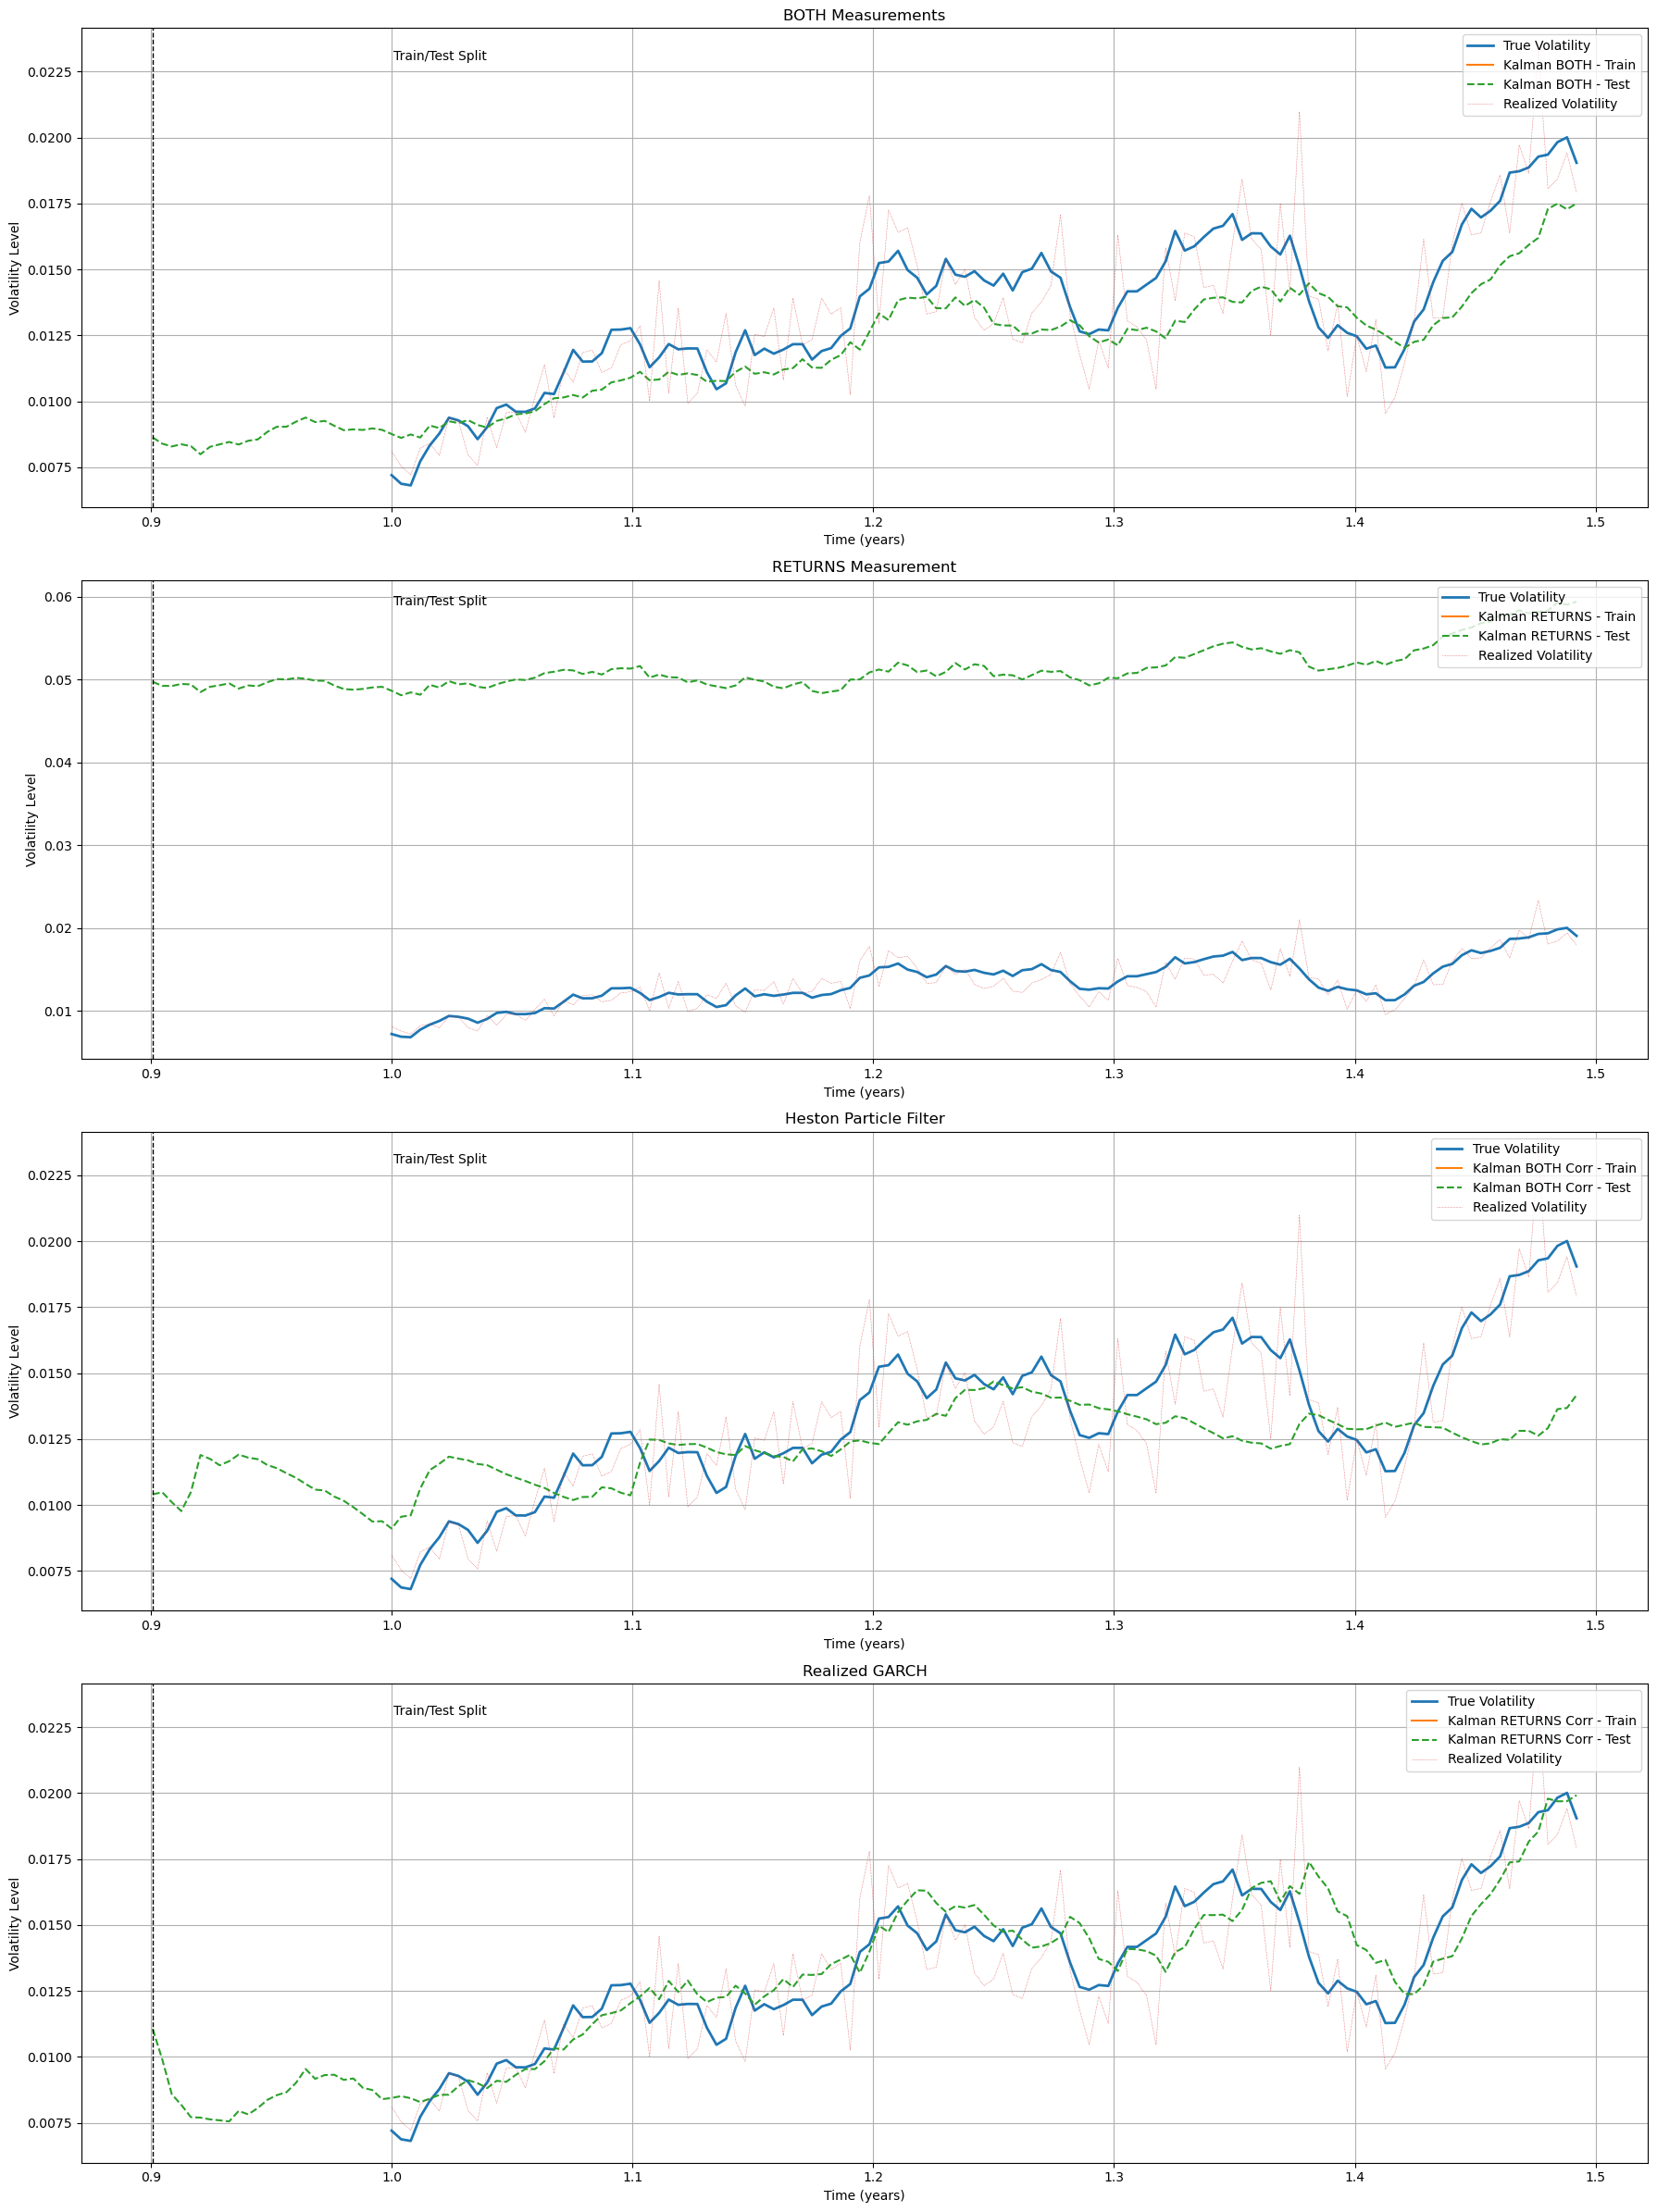

In [12]:
v_item = 'V_pred'

titles_all = ["BOTH Measurements", "RETURNS Measurement", "Heston Particle Filter", "Realized GARCH"]
labels_all = ["Kalman BOTH", "Kalman RETURNS", "Kalman BOTH Corr", "Kalman RETURNS Corr", "PF Heston", "Realized GARCH"]
train_all = [train_result_both_corr[v_item], train_result_returns_corr[v_item], V_pf_train_daily, fitted_vol]
test_all = [test_result_both_corr[v_item], test_result_returns_corr[v_item], V_pf_test_daily, predicted_vol]

Utility.plot_all_filters(
    titles=titles_all,
    labels=labels_all,
    train_filtered_list=train_all,
    test_filtered_list=test_all,
    daily_true_V=daily_true_V,
    daily_RV=daily_RV,
    daily_returns=daily_returns,
    split_index=split_index,
    burnin=252, 
    save_path=r"./output/base.png"
)

In [18]:
def qlike_loss(true_var, pred_var):
    y = np.asarray(true_var)
    h = np.asarray(pred_var)
    
    eps = np.finfo(float).eps
    ratio = y / (h + eps)
    return np.mean(ratio - np.log(ratio) - 1)

model_names = ['RV-QLKF', 'QLKF', 'PF', 'Realized GARCH']
true_variances   = daily_true_V[split_index:]
true_volatilities = np.sqrt(true_variances)

mae_scores   = {}
rmse_scores  = {}
qlike_scores = {}

for name, pred_var in zip(model_names, np.array(test_all).clip(1e-9, None)):
    pred_vol = np.sqrt(pred_var)
    
    mae_scores[name]   = mean_absolute_error(true_volatilities, pred_vol)
    rmse_scores[name]  = np.sqrt(mean_squared_error(true_volatilities, pred_vol))
    qlike_scores[name] = qlike_loss(true_variances, pred_var)

print("Results:")
for name in model_names:
    print(f"{name:18s} RMSE: {rmse_scores[name]:.6f}, "
          f"QLIKE: {qlike_scores[name]:.6f}")

Results:
RV-QLKF            RMSE: 0.001586, QLIKE: 0.033605
QLKF               RMSE: 0.038828, QLIKE: 1.961697
PF                 RMSE: 0.002643, QLIKE: 0.097015
Realized GARCH     RMSE: 0.001338, QLIKE: 0.025302


In [17]:
data = {}

data['RV-QLKF'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho'],
    [*(params_opt_both_corr[:-1] * 252), params_opt_both_corr[-1]]
))

data['QLKF'] = dict(zip(
    ['kappa', 'theta', 'xi', 'mu', 'rho'],
    [*(params_opt_returns_corr[:-1] * 252), params_opt_returns_corr[-1]]
))
data['QLKF']['sigma'] = np.nan

pf_vals = estimated_param[:, -1]
data['PF'] = {
    'kappa': pf_vals[1],
    'theta': pf_vals[2],
    'xi':    pf_vals[3],
    'mu':    pf_vals[0],
    'rho':   pf_vals[4],
    'sigma': np.nan
}

cols = ['kappa', 'theta', 'xi', 'mu', 'sigma', 'rho']
df_params = pd.DataFrame.from_dict(data, orient='index')[cols]

df_params.T

,RV-QLKF,QLKF,PF
kappa,12.6000,0.5040,2.088582
theta,0.0252,0.0252,0.025132
xi,0.2520,1.7640,0.172027
mu,0.2520,0.5040,0.010808
sigma,0.2520,NaN,NaN
rho,-0.2000,-0.0500,-0.260468


In [15]:
dict(zip(model.param_names, model.params))

{'omega': 0.00788217125920838,
 'beta': 0.7783899076171241,
 'gamma': 0.2188592558049512,
 'xi': -0.49906062376373134,
 'phi': 0.9086942550007389,
 'tau_1': 0.09735493625091027,
 'tau_2': 0.04197080155814382,
 'sigma_u': 0.17304145102089974,
 'sigma_z': 1.0}